# *Modeling Part: XGBoost*

****************************************************************************************************************************************

In [1]:
import pandas as pd
import  numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
import xgboost as xgb
from sklearn import metrics
from sklearn.metrics import accuracy_score


In [2]:
url_final = 'https://dl.dropboxusercontent.com/scl/fi/8sw7tqy1694teprjvm26p/final_dataset45.csv?rlkey=camitoqovhlg5cv1ruar0fsk8&dl=1'
df_final = pd.read_csv(url_final)

In [3]:
df_final.shape

(299384, 45)

In [4]:
df_final.head()

,COIL,DATE,TIME_START_PROCESS,SPEED_PROCESS,TEMP_Z1,PYRO_2_FRST_3_ZONE,LASER_FRN_1,LASER_FRN_2,LASER_FRN_8,LASER_FRN_9,...,SPZ2_R3,SPZ1_R1_ASS,SPEED_FILL,FILL_FORZA,FILL_TIRO,FILL_ALL,FILL_BENDING_POS,FILL_BENDING_NEG,MT_ADJUSTED,Has_Defect
0,240627,2019-03-15,14:25:23.060,-1.698350,-6.480611,-6.260562,-1.108191,-2.389473,-3.811867,-2.455160,...,-6.361568e-16,-1.352046e-15,4.325770e-16,-4.274097e-16,0.0,0.0,0.0,0.0,0.0,0.0
1,240627,2019-03-15,14:25:53.060,-1.712668,-6.518866,-6.253058,-1.108199,-2.376155,-3.795318,-2.455455,...,-6.361568e-16,-1.352046e-15,4.325770e-16,-4.274097e-16,0.0,0.0,0.0,0.0,7.0,0.0
2,240627,2019-03-15,14:26:23.060,-2.213529,-6.513475,-6.261373,-1.108177,-2.369908,-3.783512,-2.455522,...,-6.361568e-16,-1.352046e-15,4.325770e-16,-4.274097e-16,0.0,0.0,0.0,0.0,14.0,0.0
3,240627,2019-03-15,14:27:08.060,-2.212934,-6.484467,-6.161300,-1.108188,-2.340920,-3.760286,-2.455393,...,-6.361568e-16,-1.352046e-15,4.325770e-16,-4.274097e-16,0.0,0.0,0.0,0.0,21.0,0.0
4,240627,2019-03-15,14:27:38.060,-1.811965,-6.445186,-5.887232,-1.108134,-2.305111,-3.712663,-2.454928,...,2.082642e-01,-1.395796e+00,4.325770e-16,-4.274097e-16,0.0,0.0,0.0,0.0,28.0,0.0


**'df_final'** is now our final dataframe with the selected features and the target column of interest ('Has_Defect') at the end

#### Splitting our data into Train, Validation and Test sets

To ensure that the same coils are not split across both the training and testing sets, thereby preventing data leakage, we need to stratify the split based on the coil ID. This means we should split our dataset in such a way that all records belonging to a specific coil are either entirely in the training set or entirely in the testing set

In [5]:
# Get unique coil IDs and split them
unique_coils = df_final['COIL'].unique()
train_coils, test_coils = train_test_split(unique_coils, test_size=0.2, random_state=42)
train_coils, val_coils = train_test_split(train_coils, test_size=0.25, random_state=42)  # Splitting the remaining 80% into 60% train and 20% validation

# Split the DataFrame into training, validation, and testing sets based on coil IDs
train_df = df_final[df_final['COIL'].isin(train_coils)]
val_df = df_final[df_final['COIL'].isin(val_coils)]
test_df = df_final[df_final['COIL'].isin(test_coils)]


In [6]:
target = "Has_Defect"

# Prepare the data
X_train = train_df.drop(['COIL', 'MT_ADJUSTED', 'DATE', 'TIME_START_PROCESS', target], axis=1)  
y_train = train_df[target]    

X_val = val_df.drop(['COIL', 'MT_ADJUSTED', 'DATE', 'TIME_START_PROCESS', target], axis=1)
y_val = val_df[target]

X_test = test_df.drop(['COIL', 'MT_ADJUSTED', 'DATE', 'TIME_START_PROCESS', target], axis=1)   
y_test = test_df[target]     

### XGBoost

In [7]:
param_grid = {
    'n_estimators': [100, 200],  # Number of gradient boosted trees.
    'learning_rate': [0.05, 0.1],  # Step size shrinkage used to prevent overfitting.
    'max_depth': [3, 5],  # Maximum tree depth for base learners.
    'min_child_weight': [1, 2],  # Minimum sum of instance weight needed in a child.
    'gamma': [0, 0.1],  # Minimum loss reduction required to make a further partition.
    'subsample': [0.8, 1.0],  # Subsample ratio of the training instances.
    'colsample_bytree': [0.8, 1.0],  # Subsample ratio of columns when constructing each tree.
}


# Create the XGBoost classifier instance
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, 
                           scoring='accuracy', cv=3, n_jobs=1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# After grid search completes
print(f"Best parameters found: {grid_search.best_params_}")
best_xgb_clf = grid_search.best_estimator_

Fitting 3 folds for each of 128 candidates, totalling 384 fits


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   2.0s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   1.5s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   1.9s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=200, subsample=0.8; tota

In [12]:
# Predict on the validation set
y_val_pred_xgb = best_xgb_clf.predict(X_val)
# Calculate the accuracy of the model on the validation set
val_acc_xgb = accuracy_score(y_val, y_val_pred_xgb)
print(f"Validation Accuracy XGBoost: {val_acc_xgb}\n")
# Print out the classification report which provides a summary of the model's performance
print("**Classification report for XGBoost Classifier on the validation set:**\n")
print(classification_report(y_val, y_val_pred_xgb))

# Make predictions on the test set using the best model
y_test_pred_xgb = best_xgb_clf.predict(X_test)
# Calculate the accuracy of the model on the test set
test_acc_xgb = accuracy_score(y_test, y_test_pred_xgb)
print(f"Testing Accuracy XGBoost: {test_acc_xgb}\n")
# Print out the classification report which provides a summary of the model's performance
print("**Classification report for XGBoost Classifier on the test set:**\n")
print(classification_report(y_test, y_test_pred_xgb))

Validation Accuracy XGBoost: 0.7790927021696252

**Classification report for XGBoost Classifier on the validation set:**

              precision    recall  f1-score   support

         0.0       0.83      0.85      0.84     40144
         1.0       0.68      0.65      0.66     20189

    accuracy                           0.78     60333
   macro avg       0.75      0.75      0.75     60333
weighted avg       0.78      0.78      0.78     60333

Testing Accuracy XGBoost: 0.7864450545858666

**Classification report for XGBoost Classifier on the test set:**

              precision    recall  f1-score   support

         0.0       0.81      0.85      0.83     38134
         1.0       0.73      0.68      0.71     23054

    accuracy                           0.79     61188
   macro avg       0.77      0.77      0.77     61188
weighted avg       0.78      0.79      0.78     61188



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


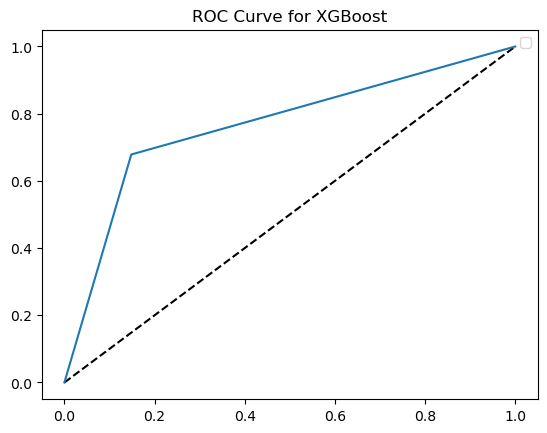

In [13]:
# Plot the ROC curve for XGBoost 
fpr_xgboost, tpr_xgboost, _ = metrics.roc_curve(y_test, y_test_pred_xgb)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_xgboost, tpr_xgboost)
plt.title('ROC Curve for XGBoost')
plt.legend()
plt.show()

In [14]:
# Features importances of the model
feature_importances_xgb = best_xgb_clf.feature_importances_
# Summary of feature importance
summary_imp = pd.DataFrame(list(zip(X_train.columns, feature_importances_xgb)), columns=["Feature", "Importance"])
summary_imp = pd.DataFrame(summary_imp.sort_values(by="Importance", ascending=False))
print("Summary of feature importance:")
print(summary_imp)


Summary of feature importance:
                 Feature  Importance
1                TEMP_Z1    0.085516
2     PYRO_2_FRST_3_ZONE    0.077704
14              AIR_Z2_1    0.072428
35            FILL_FORZA    0.069969
36             FILL_TIRO    0.048696
21          LASER_RAFF_9    0.042701
37              FILL_ALL    0.035500
7              AIR_CH4_1    0.035254
15  FRN_FURNACE_PRESSURE    0.030495
28             DEC_H2SO4    0.030177
9              AIR_CH4_3    0.029387
26              ELET_FE2    0.028635
13              AIR_Z1_1    0.025950
25            ELET_H2SO4    0.025729
29               DEC_FE2    0.025061
3            LASER_FRN_1    0.024409
20                 EXT_1    0.023449
8              AIR_CH4_2    0.020730
0          SPEED_PROCESS    0.020099
12             AIR_CH4_6    0.019497
16            TIRO_FORNO    0.019305
39      FILL_BENDING_NEG    0.018352
10             AIR_CH4_4    0.017585
32               SPZ2_R3    0.016919
27              DEC_TEMP    0.016891
38     

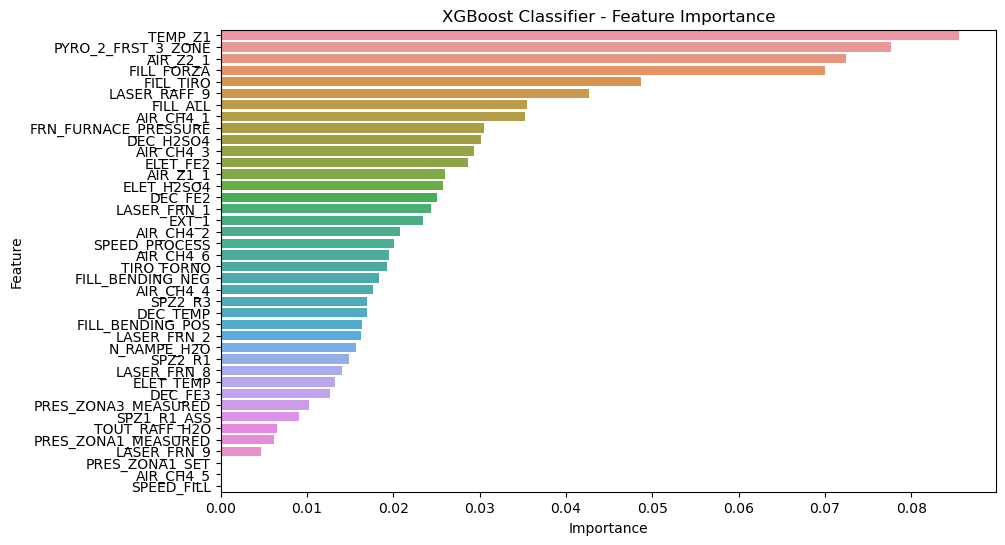

In [15]:
plt.figure(figsize=(10, 6))
sns.barplot(x=summary_imp["Importance"], y=summary_imp["Feature"])
plt.title('XGBoost Classifier - Feature Importance')
plt.show()

- Bars: Each horizontal bar corresponds to a feature and its length represents the feature's importance score. Longer bars denote features that are more important in the model's decision-making process.
- Top Features: The features at the top, such as "PYRO_2_FRST_3_ZONE" and "TEMP_Z1", are the most important ones, contributing more significantly to the model's decisions.
  
Decision-Making and Insight:
- Highly important features could be key drivers of the outcome (in this case, whether a metal coil is defective) and may be areas to focus on for intervention or further analysis.
- The importance plot can also guide feature selection for model simplification or to understand which variables may warrant further data collection or engineering.

Considerations:
- Feature importance does not imply causation. It merely indicates which features the model relies on to make predictions.
- The importance values are relative to the dataset and model. They do not convey absolute significance but rather how much each feature contributes compared to the others in this specific model.